# Executive Summary
- The stated goal of this project is to predict the main progamming language of a repository on Github based on the commensurate README file contents.
- We were able to programatically scrape some of the most popular repositories on Github, and from them collect the repository name, main programming language used, and the content of the README file from each. 
- All the data collected was compiled into a DataFrame with the anticipation that we will be able to glean from it what the main programming language is of the repository via Natural Language Processing methods on the corresponding README file content.
- While the data we collected is static, the Github repositories are dynamic and ever-changing. Therefore is important to note the data was collected from these repositories on the morning of October 18, 2022.
- The decision tree bags of word has best outcome in our training model and was able to achived 50% accuracy
- We created a function to predict the outcome. we successfully predict the language based on a random (not so random), readme.

In [ ]:
# import libaries
import pandas as pd
import numpy as np

# import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning libaries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn import tree

# import NLP tool
from wordcloud import WordCloud
import re

# import stat test
from scipy import stats

# import self-created functions
import prepare
import project_acquire
import explore

# ignore warning
import warnings
warnings.filterwarnings("ignore")

# Wrangle

In [2]:
# use prepare module wrangle data function to acquire data
data=pd.read_json('data.json')

In [3]:
# check if we capture any duplicated repo/readme
data.duplicated().value_counts()

False    783
True     217
dtype: int64

In [4]:
# we are going to drop those duplicated repo/readme
data=data.drop_duplicates()
data.duplicated().value_counts()

False    783
dtype: int64

### Takeaway
- The readme acquired contains foreign language, we will going to drop those languages that is not in English, due to we acquired about 1000 rows, we met the requirement of at least 100 rows.

#### Install the package needed to detect the language
- \# pip install langdetect

### Key takeaway
- The most starred README data on github was collected on October 18, 2022 due to error code found, the previous dataset was deleted and re-collected on October 18th.
- The data has 1000 rows
- We found that the readme contains foreign language, therefore, we downloaded a langdetect package for further wrangle the dataset
- we also spot some 'none' value in our language, we will do further wrangle with that data as well
- Following this acquire, we are going to prepare for our exploration

In [5]:
# clean the data acquired
# We are acquire the data that is cleaned up with tokenized, stemmed, and lemmatized
# add those columns into the dataframe and create a final data frame
df=prepare.wrangle_data(data)

In [6]:
# we will going to drop 'none' value in our language column
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 2 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             715 non-null    object
 1   language         715 non-null    object
 2   readme_contents  715 non-null    object
 3   stemmed          715 non-null    object
 4   lemmatized       715 non-null    object
 5   clean_tokens     715 non-null    object
dtypes: object(6)
memory usage: 39.1+ KB


In [7]:
# we will going to use the installed package 
# to filter out the readme contents that is in English only

# we are going to import a new libary for this
import langdetect as ld

# we created a new function to detect the non-english language in read me
# the function will return the result when it is not in english,, elso will not return the result
def is_en(txt):
    try:
        return ld.detect(txt)!='en'
    except:
        return False

# we applied the function we created 
nodf = df[df['readme_contents'].apply(is_en)]

In [8]:
# drop those that is not in english
df=df.drop(index=(nodf.index))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670 entries, 2 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             670 non-null    object
 1   language         670 non-null    object
 2   readme_contents  670 non-null    object
 3   stemmed          670 non-null    object
 4   lemmatized       670 non-null    object
 5   clean_tokens     670 non-null    object
dtypes: object(6)
memory usage: 36.6+ KB


- our dataframe should contains numerical data for better exploration, therefore, we are going to created some columns that able to represent the overall struture of the dataframe. we picked df.lemmatized

In [9]:
# we use the explore module to create those numerical columns other neccessary info for exploration
df=explore.feature_engineering(df)

In [10]:
# create a final local file for easy access
# df.to_csv('data.csv')

In [11]:
# checking the describe
df.describe()

,word_count_simple,word_count,unique_count,non_single_count,percent_unique,percent_repeat,percent_one_word,percent_non_single
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,757.607463,736.267164,371.826866,648.870149,0.658900,0.341100,0.774396,0.884378
std,1516.014172,1482.858501,486.479246,1316.713410,0.143099,0.143099,0.083878,0.089733
min,2.000000,2.000000,2.000000,2.000000,0.231533,0.000000,0.458537,0.191489
25%,185.250000,183.000000,130.000000,161.250000,0.565173,0.244310,0.716450,0.837635
50%,373.500000,364.000000,233.000000,325.500000,0.653592,0.346408,0.765826,0.879077
75%,785.250000,758.750000,437.000000,668.750000,0.755690,0.434827,0.828220,0.949819
max,19158.000000,18994.000000,4717.000000,17104.000000,1.000000,0.768467,1.000000,1.000000


### Key takeaway so far
- The numerical columns created for better exploration
- The foreign language readme columns dropped to support our exploration
- we ended up have 669 columns remained
- The describe showed that there is significant jump in those counts, we believe we need to handle the outlier in our next step

In [12]:
# create a function to trim the outlier and drop null values again
def remove_outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    new_df = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return new_df

In [13]:
# check the data after trim the outlier
new_df=df[remove_outlier(df)]
new_df=new_df.dropna()
print('We drop ',round((1-len(new_df)/len(df))*100,2),'% rows due to outlier')

We drop  12.54 % rows due to outlier


# Overall Wrangle Takeaway
- The data aquired on October 18th, 2022 with 1000 rows
- The data contains 'none' value in the language column, we dropped all 'none' values 
- The data contains foreign language in the readme contents column, we drop all those non-english values
- We create some numerical columns for further exploration
- we drop those outliers 
- We finalized with 586 rows, and ready for exploration

# Exploration

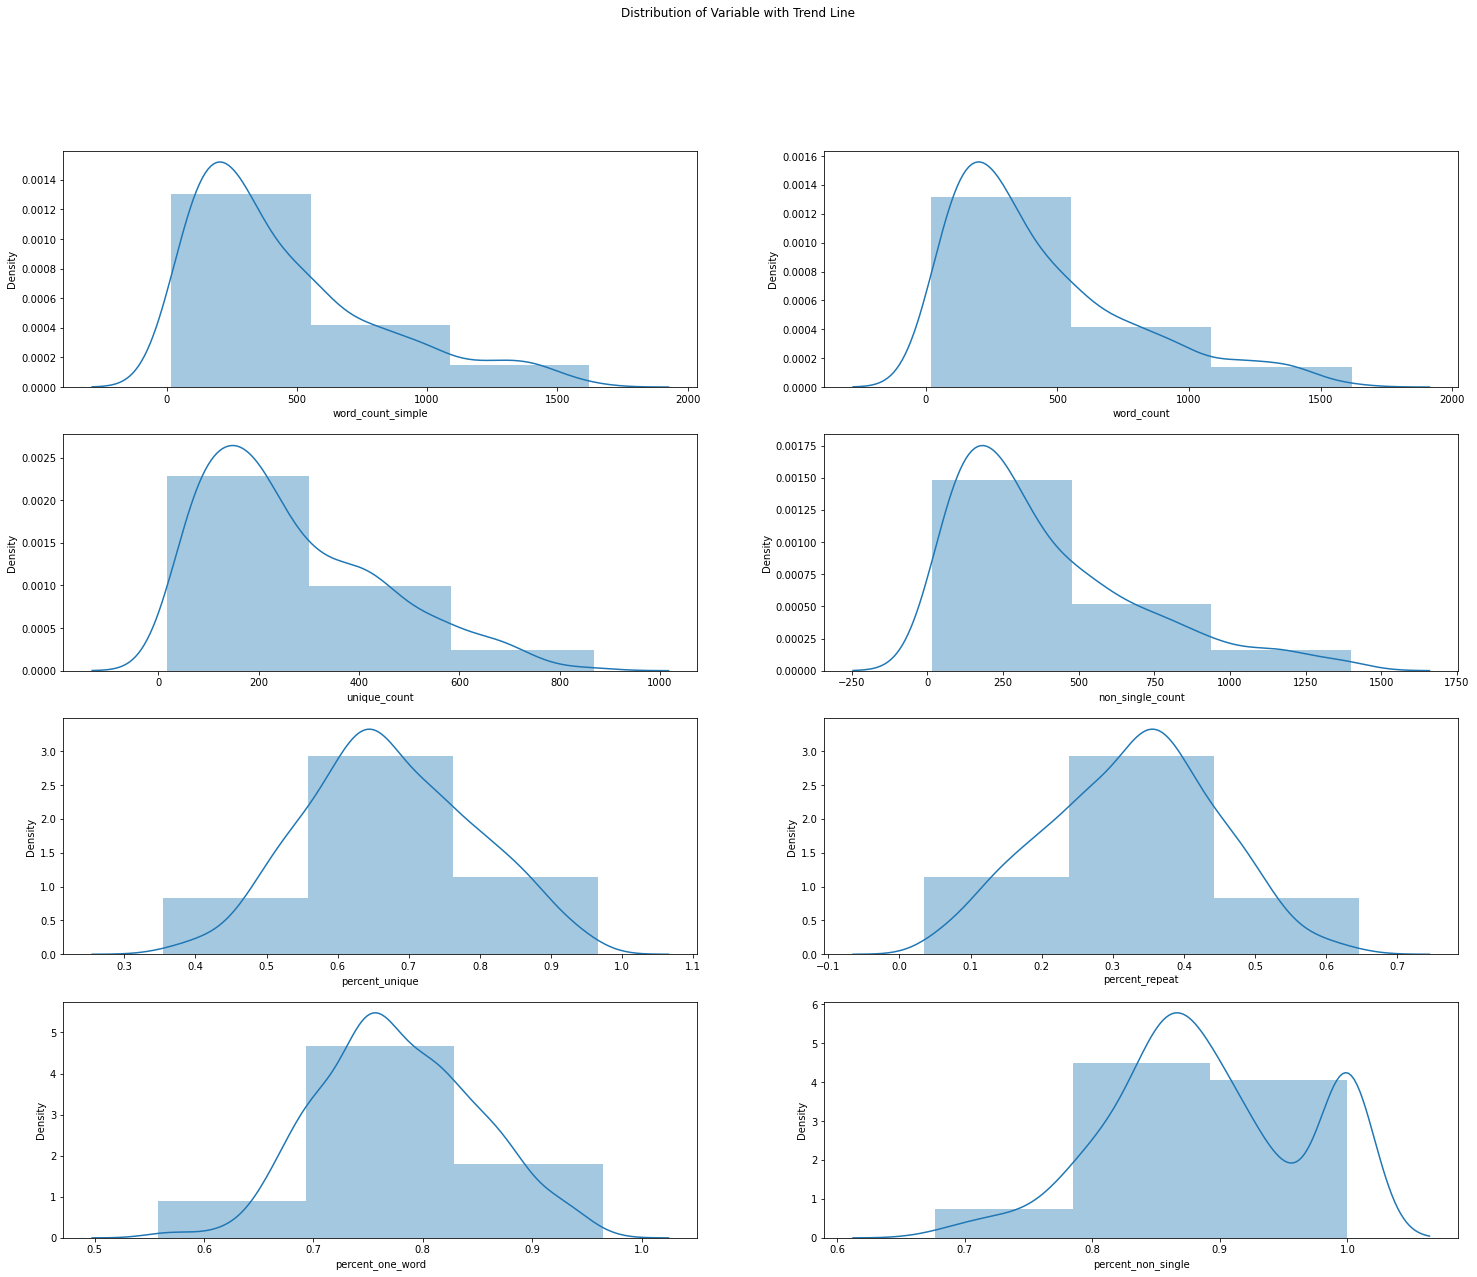

'We are showing non-object histogram with a trendline, that the distribution of the data\nis normal for unique and repeat, \nbut interestingly, the word count and non-single count is left skew'

In [14]:
f = plt.figure(figsize=(25,20))
continuous_data = new_df.select_dtypes(exclude=['object'])
plt.suptitle("Distribution of Variable with Trend Line")
for i in range(0,8):
    f.add_subplot(4,2, i+1)
    sns.distplot(continuous_data.iloc[:,i], bins=3)
plt.show()
'''We are showing non-object histogram with a trendline, that the distribution of the data
is normal for unique and repeat, 
but interestingly, the word count and non-single count is left skew'''

<AxesSubplot:xlabel='percent_one_word', ylabel='percent_repeat'>

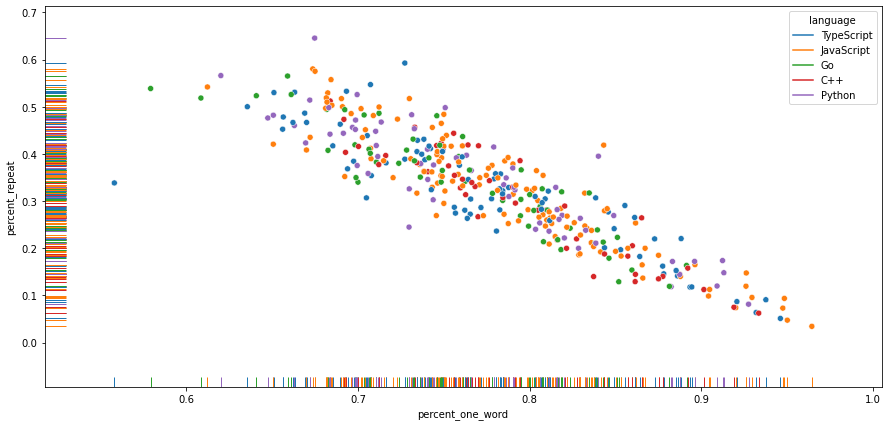

In [337]:
# See if we can find corerealtion between percent one word and percent repeat by language
sns.scatterplot(data=exp_df, x="percent_one_word", y="percent_repeat",hue='language')
sns.rugplot(data=exp_df, x="percent_one_word", y="percent_repeat",hue='language')

- we couldn't find any cluster in this

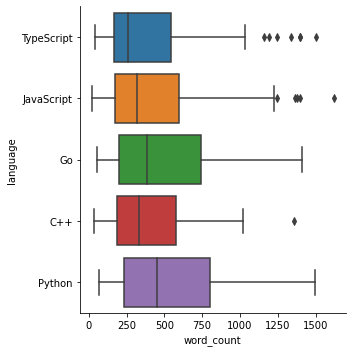

In [343]:
# Word count with catplot
sns.catplot(data=exp_df, y="language", x="word_count", kind="box")
plt.show()

- The python has significant word count in between 250 to 750
- Javascipt seems to have outlier that might set off the real outcome

In [344]:
# set up the environment to answer those questions.
# we find out that the top  5 languages are JavaScript, TypeScript, Python, Go and C++
# We are going to drop other columns but keep those top 5 languages
new_df.language.value_counts().head(10)

JavaScript    127
TypeScript     76
Python         63
Go             56
C++            46
Java           43
Rust           18
C              17
C#             17
HTML           16
Name: language, dtype: int64

In [345]:
# we are going to create the new dataframe
a=['JavaScript', 'TypeScript', 'Python', 'Go', 'C++']
exp_df=new_df[new_df.language.isin(a)]

## Q1: What are the most common words in READMEs?

In [17]:
# get the freq from created module 
freq_df=explore.freq_df(exp_df)

In [18]:
# find out the top 10 most common word in read me
freq_df.sort_values(by='all',ascending=False).head(10)

,all,JavaScript,TypeScript,Python,Go,C++
use,1135,386,233,211,192,113
install,821,232,129,203,130,127
using,809,288,146,170,120,85
run,767,230,180,141,140,76
file,764,263,131,116,165,89
build,734,146,130,39,169,250
code,727,197,173,162,92,103
version,670,212,126,120,121,91
support,629,174,127,97,130,101
project,556,135,139,105,86,91


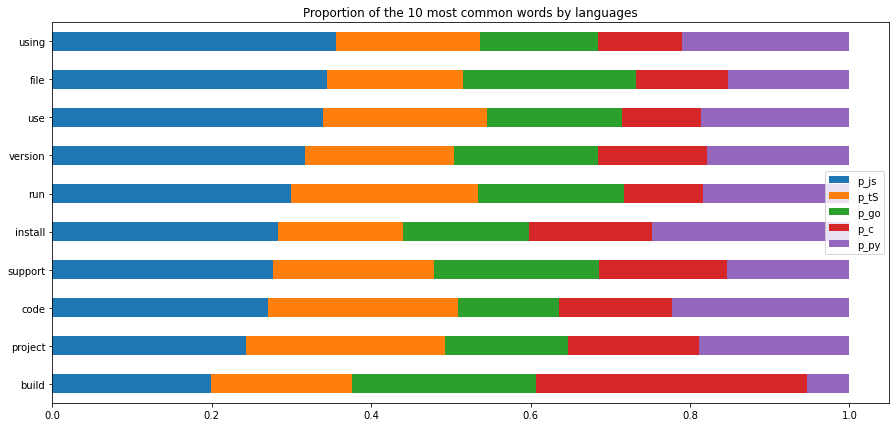

In [19]:
# figure out the percentage of JavaScript versus Python top 10 most common word by proportion
plt.rcParams["figure.figsize"] = (15,7)
(freq_df
 .assign(p_js=freq_df.JavaScript / freq_df['all'],
         p_py=freq_df.Python / freq_df['all'],
        p_tS=freq_df.TypeScript / freq_df['all'],
        p_go=freq_df.Go / freq_df['all'],
        p_c=freq_df['C++'] / freq_df['all'])
 .sort_values(by='all')
 [['p_js','p_tS','p_go','p_c', 'p_py']]
 .tail(10)
 .sort_values('p_js')
 .plot.barh(stacked=True))
plt.title('Proportion of the 10 most common words by languages')
plt.show()

## Q1 Key Takeaway
- The tope ten most used words are: use,install,using,run,file,build,code,version,support,project
- The word build used significantly in c++ language while the javascript use all top 10 words consistently higher than others
- The word 'use' and 'run' use less frequently in C++ language  
- The word 'build' is less likely use in python

## Q2 Does the length of the README vary by programming language? If not whether the bigram different per language?

In [20]:
q2=exp_df.copy()
q2.groupby('language')['word_count'].mean()

language
C++           422.456522
Go            499.232143
JavaScript    431.078740
Python        543.920635
TypeScript    409.447368
Name: word_count, dtype: float64

#### Q2 key takeaway so far
- No, the length of the README is not vary by the programming language.
- We will explore bigram per language next to further explore whether the bigram is different by language

In [21]:
# bigram per language, we will extract already build function in explore module
q2_2=explore.bigram_clean(exp_df)
q2_2.sort_values(by='all_bigram',ascending=False).head(10)

,,all_bigram,JavaScript,TypeScript,Python,C++,Go
open,source,115,29,30,17,16,23
et,al,87,0,0,87,0,0
npm,install,81,53,24,0,0,0
make,sure,76,18,27,0,10,11
source,code,72,0,18,0,33,0
9,9,71,0,0,58,0,0
command,line,71,22,0,0,15,0
npm,run,67,48,18,0,0,0
getting,started,67,19,19,0,0,17
get,started,61,22,13,0,0,12


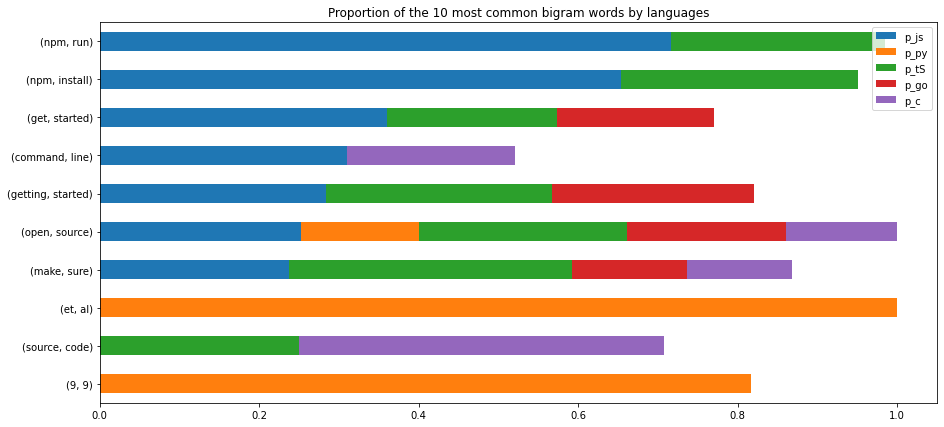

In [22]:
plt.rcParams["figure.figsize"] = (15,7)
(q2_2
 .assign(p_js=q2_2.JavaScript / q2_2['all_bigram'],
         p_py=q2_2.Python / q2_2['all_bigram'],
        p_tS=q2_2.TypeScript / q2_2['all_bigram'],
        p_go=q2_2.Go / q2_2['all_bigram'],
        p_c=q2_2['C++'] / q2_2['all_bigram'])
 .sort_values(by='all_bigram')
 [['p_js','p_py','p_tS','p_go', 'p_c']]
 .tail(10)
 .sort_values('p_js')
 .plot.barh(stacked=True))
plt.title('Proportion of the 10 most common bigram words by languages')
plt.show()

## Q2: Key Takeaway:
- The Python and TypeScript has unique word that belong to them in bigram
- The language itself doesn't varied the progrma language readme length
- The Bigram has significant different in different language
- Interestingly, the python bigram ''et, al'' has not seem before, potentially suspected the code broke somewhere

## Q3: Do different programming languages use a different number of unique words? if yes, whether there can find some corelation between the languages?

In [23]:
# Create a copy and then set up the environment for questions 3
q3=exp_df.copy()
q3=q3.set_index('language')

In [24]:
# change the unique word into string from array
q3.unique_words=q3.unique_words.astype('string')
q3.groupby('language')['unique_count'].mean().sort_values()

language
TypeScript    243.973684
JavaScript    260.110236
C++           269.869565
Go            294.160714
Python        317.968254
Name: unique_count, dtype: float64

### Key Takeaway So far
- Yes they use different number of unique word, and the javaScript use the unique word most often
- Next step would be checking out will those unique word same across the languages

In [25]:
# Set up the envirrnemnt, create each dataframe based on their language.
p1=q3[q3.index=='JavaScript']
p2=q3[q3.index=='TypeScript']
p3=q3[q3.index=='Python']
p4=q3[q3.index=='Go']
p5=q3[q3.index=='C++']

In [26]:
# Set the environment up for each dataframe
# Create a list of unique words
p1_words = (' '.join(p1.unique_words))
p1_words = re.sub(r'[^\w\s]', '', p1_words).split()
p2_words = (' '.join(p2.unique_words))
p2_words = re.sub(r'[^\w\s]', '', p2_words).split()
p3_words = (' '.join(p3.unique_words))
p3_words = re.sub(r'[^\w\s]', '', p3_words).split()
p4_words = (' '.join(p4.unique_words))
p4_words = re.sub(r'[^\w\s]', '', p4_words).split()
p5_words = (' '.join(p5.unique_words))
p5_words = re.sub(r'[^\w\s]', '', p5_words).split()

In [27]:
# Check how many of them are unique_words in compare to other languages
[{'All unique words in JavaScript':len(set(p1_words).difference(p2_words,p3_words,p4_words,p5_words))},
{'All unique words in TypeScript':len(set(p2_words).difference(p1_words,p3_words,p4_words,p5_words))},
{'All unique words in Python':len(set(p3_words).difference(p1_words,p2_words,p4_words,p5_words))},
{'All unique words in Go':len(set(p4_words).difference(p2_words,p3_words,p1_words,p5_words))},
{'All unique words in C++':len(set(p5_words).difference(p2_words,p3_words,p4_words,p1_words))}]

[{'All unique words in JavaScript': 10625},
 {'All unique words in TypeScript': 5315},
 {'All unique words in Python': 7691},
 {'All unique words in Go': 5033},
 {'All unique words in C++': 3948}]

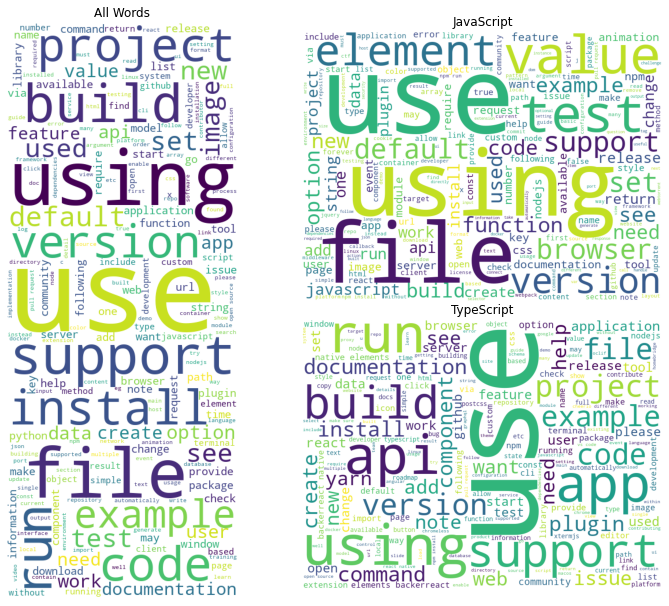

In [28]:
# visualize with word cloud
explore.vis_cloud1(exp_df)

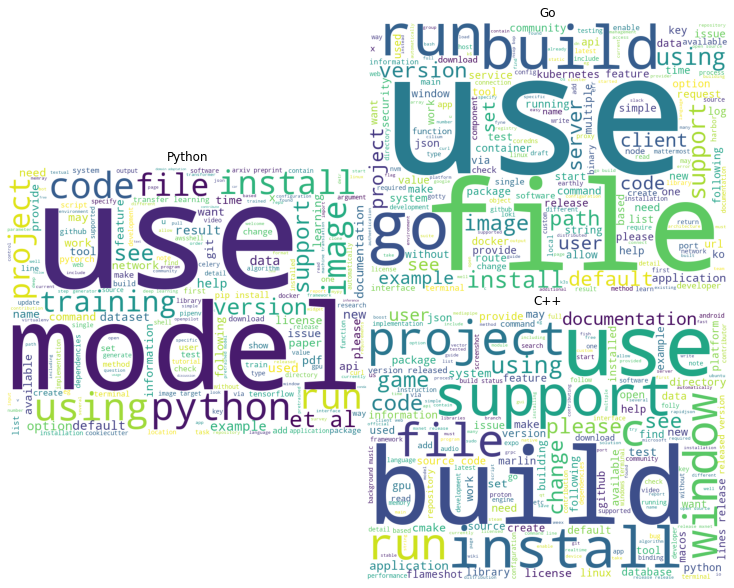

In [29]:
# visualize with word cloud
explore.vis_cloud2(exp_df)

### Q3 Key Takeaway so far
- Each Language has unique word the distinguish to other language
- By language that Javascript contributed the most unique words

- We then conduct a hypothesis test based on the information we got
- H0= There is no difference between unique words and language
- H1= There is difference between unique words and language 
- we set the alpha = 0.05

In [58]:
# create a dataframe for this question
q4=exp_df.copy()

In [59]:
# find out how many total unique word used based on their language 
q4.groupby('language')['unique_count'].sum()

language
C++           12414.0
Go            16473.0
JavaScript    33034.0
Python        20032.0
TypeScript    18542.0
Name: unique_count, dtype: float64

In [299]:
# find out how many total non unique word used based on their language 
q4.groupby('language')['non_single_count'].sum()

language
C++           17276.0
Go            24721.0
JavaScript    48962.0
Python        29615.0
TypeScript    27704.0
Name: non_single_count, dtype: float64

In [303]:
# create a dataframe for chi square test
columns = ['C++', 'Go','JavaScript','Python','TypeScript']
index = ['Unique_Word', 'Non_unique']

observed = pd.DataFrame([[12414,16473,33034,20032,18542], [17276, 24721,48962,29615,27704]], index=index, columns=columns)
observed

,C++,Go,JavaScript,Python,TypeScript
Unique_Word,12414,16473,33034,20032,18542
Non_unique,17276,24721,48962,29615,27704


In [306]:
# conduct chi square test

chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p}')

Observed

[[12414 16473 33034 20032 18542]
 [17276 24721 48962 29615 27704]]
---
Expected

[[11993.6510393  16640.83734971 33123.32134114 20055.533619
  18681.65665084]
 [17696.3489607  24553.16265029 48872.67865886 29591.466381
  27564.34334916]]
---

chi^2 = 29.7591
p     = 5.479461740706879e-06


- we reject the null hypothesis based on our p value outcome 

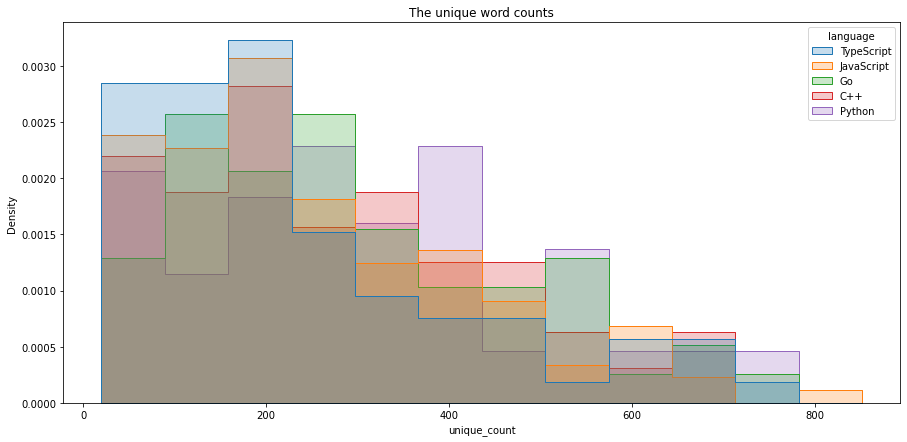

In [302]:
plt.title('The unique word counts')
sns.histplot(exp_df, x='unique_count',hue='language'
             ,element="step",stat="density", common_norm=False,)
plt.show()

## Q3 Overall Key Takeaway
- we did a hypothesis test, which confirmed our inital thought that the unique word has contribute to the language
- The Javascript has most unique word in compare to other languages
- Majority of those unqiue word counts is focusing in 200, and they are left skew

## Q4 whether the mean of percentage_one_word in python is greater than the mean of percentage one word in JavaScript

- H0: Mean of &one word in python <= Mean of &one word in javascript
- Ha: Mean of &one word in python > Mean of &one word in javascript

In [325]:
# create a new dataframe for our question
q4=exp_df.copy()
python=q4[q4.language=='Python']['percent_one_word']
java=q4[q4.language=='JavaScript']['percent_one_word']

In [327]:
# check vairance
python.var()==java.var()

False

In [329]:
# test
t, p = stats.ttest_ind(python, java, equal_var=False)
t, p / 2


(-1.4657486799221333, 0.07268305247486212)

In [333]:
if p / 2 > 0.05:
    print("Mean of &one word in python > Mean of &one word in javascript")
elif t < 0:
    print("Mean of &one word in python > Mean of &one word in javascript")
else:
    print("Mean of &one word in python <= Mean of &one word in javascript")

Mean of &one word in python > Mean of &one word in javascript


## Q4 takeaway
- The mean of the one word % in python is greater than the mean of one word in javascript
- Which means that the python use more unique word than Java in compare to their overall length
- As we previously found out that the overall number of unique word, javascript has most significant
- So we can conclude that although Java is using a lot unique word, but that proportion to their readme the python use more unique word

# Explroation Key Takeaway
- although Java is using a lot unique word, but that proportion to their readme the python use more unique word
- The amount of unique word has contribute to the language
- Each Language has unique word the distinguish to other language
- The tope ten most used words are: use,install,using,run,file,build,code,version,support,project

# Modeling

In [278]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

In [279]:
# Establish Baseline
baseline=(y_train=='JavaScript').mean()
print('The baseline accuracy is ',baseline)

The baseline accuracy is  0.33636363636363636


In [286]:
# Decision tree model, bag of words
cv = CountVectorizer()
X = cv.fit_transform(exp_df.lemmatized)
y = exp_df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

bwtree = DecisionTreeClassifier(max_depth=12, random_state=123)
bwtree.fit(X_train, y_train)

print(f'Accuracy Score: {bwtree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 67.57%


In [287]:
# TF-IDF approach
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(exp_df.lemmatized)
y = exp_df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

tftree = DecisionTreeClassifier(max_depth=17, random_state=13)
tftree.fit(X_train, y_train)

print(f'Accuracy Score: {tftree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 51.35%


In [288]:
# Bigram approach
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(exp_df.lemmatized)
y = exp_df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

bitree = DecisionTreeClassifier(max_depth=16, random_state=13)
bitree.fit(X_train, y_train)

print(f'Accuracy Score: {bitree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 50.00%


In [289]:
# Tri-gram?
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(exp_df.lemmatized)
y = exp_df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

titree = DecisionTreeClassifier(max_depth=12, random_state=123)
titree.fit(X_train, y_train)

print(f'Accuracy Score: {titree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 39.19%


In [291]:
# The best model is bags of word with decision tree
# Decision tree model, bag of words
cv = CountVectorizer()
X = cv.fit_transform(exp_df.lemmatized)
y = exp_df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

bwtree = DecisionTreeClassifier(max_depth=12, random_state=123)
bwtree.fit(X_train, y_train)

preds = bwtree.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         C++       0.20      0.14      0.17         7
          Go       0.88      0.50      0.64        14
  JavaScript       0.58      0.70      0.63        27
      Python       0.47      0.88      0.61         8
  TypeScript       0.23      0.17      0.19        18

    accuracy                           0.50        74
   macro avg       0.47      0.48      0.45        74
weighted avg       0.50      0.50      0.48        74



In [292]:
# Create a function to predict the program language use our created model
def predict_readme_language(string):
    string = prepare.clean_html(string)
    string = prepare.basic_clean(string)
    string = prepare.tokenize(string)
    string = prepare.remove_stopwords(string)
    string = prepare.lemma(string)
    string = cv.transform([string])
    
    return bwtree.predict(string)

In [293]:
# use old Readme to see whether the function can predict the outcome
testfile='''Pipeless
========

*A simple library for building a data pipeline.*

|Build Status|

It's an advanced version of this:
``function4(function3(function2(function1(0))))``

It looks like this:

.. code-block:: python

    from pipeless import pipeline

    error_handler = lambda item, exception: None
    function, run, _ = pipeline(error_handler)


    @function
    def add_one(_):
        return _ + 1
    
    list(run([1, 2, 3]))  # [2, 3, 4]


    @function
    def doubler(_):
        yield _
        yield _ * 2

    list(run([1, 2, 3]))  # [2, 4, 3, 6, 4, 8]

*  Pipelines operate over a source iterator (like a generator or a list).
*  Functions can return 1 Item, None to drop the item, or
   a generator. If a generator is given, the items all continue along the pipeline,
   creating a fork.
   
   ::
   
    +-----------------------------------+
    |                                   |
    |    add_one   doubler              |
    |    [1]--|-2----\-----2            |
    |    Input        -----4            |
    |                    Output [2,4]   |
    |                                   |
    +-----------------------------------+

*  All exception are caught and handled by the optional ``error_handler`` input argument
   to prevent one broken item from stopping the flow. If the handler returns something,
   that something continues on down the pipeline.
*  Functions can be grouped with an optional argument on the annotator i.e. ``@function('my_group')``.
   Set up your functions this way and you can skip groups with the ``function_groups_to_skip`` argument
   on the pipeline runner.

See the docstrings in ``pipeline.py`` for more information!

Versions:

- *2.0* Removed cli generator and optional tuples
- *1.1* Function builders optional.
- *1.0.1* Fixed ordering problem.

Installation
~~~~~~~~~~~~

Supports Python 2.6, 2.7, 3.x, pypy.

.. code-block:: bash

    pip install pipeless

or copy ``pipeless.py`` into your project.

Support
~~~~~~~

Need some help? Send me an email at theandychase@gmail.com and I'll do my best to help you.

Contribution
~~~~~~~~~~~~

Send me suggestions, issues, and pull requests on Github and I'll gladly review them!

Licence
~~~~~~~

The MIT License (MIT)

Copyright (c) 2013 Andrew Chase

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the
"Software"), to deal in the Software without restriction, including
without limitation the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so, subject to
the following conditions:

The above copyright notice and this permission notice shall be included
in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS
OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY
CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,
TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

.. |Build Status| image:: https://travis-ci.org/andychase/pipeless.svg?branch=master
   :target: https://travis-ci.org/andychase/pipeless'''

**The [TestFile](https://github.com/andychase/pipeless/blob/master/readme.rst) extracted from the user: pipeless on October 19th, it is a python readme**

In [294]:
# The model successfully predict the outcome
predict_readme_language(testfile)

array(['Python'], dtype=object)

## Model takeaway
- The decision tree bags of word has best outcome in our training model
- We used that, and was able to achived 50% accuracy
- We created a function to predict the outcome
- we successfully predict the language based on a random (not so random), readme.

# Conclusion, Recommendation, Next Step

## Conclusion
- The decision tree bags of word has best outcome in our training model
- We used that, and was able to achived 50% accuracy
- We created a function to predict the outcome
- we successfully predict the language based on a random (not so random), readme.
- although Java is using a lot unique word, but that proportion to their readme the python use more unique word
- The amount of unique word has contribute to the language
- Each Language has unique word the distinguish to other language
- The tope ten most used words are: use,install,using,run,file,build,code,version,support,project

## Recommendation
- we found that unique word can help to predict the language
- We believe accuracy becomes uncertain when we try to predict more language, so try to predict three most commonly used language

## Next Step
- we found repeat rows in our dataset, we believe there are errors in our coding, we need to find out a way to use api scraping without capture same information
- Instead of five languages, we will reduce it to three, so we can increase our accuracy